load, remove duplicates and clean non metaphor dataset

In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

sns.set(context="talk", style="darkgrid")

# load the dataframe

In [2]:
CWD = os.getcwd()
folder = "data"
file = "NoMetaphor.csv"

file = "/".join( (CWD, folder, file) )

df = pd.read_csv(file, index_col=0)
df.drop(columns=["Filename"],inplace=True)
df.reset_index(inplace = True)

df["Metapher"] = 0
df["Kandidat"] = 0
df["Nein"] = 1

df["orig"] = df.Textstelle

df = df[["index", "Textstelle", "Metapher", "Kandidat", "Nein",
         "Metapher?", "Fokus", "Rahmen", "Annotator", "orig"]]
df

,index,Textstelle,Metapher,Kandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig
0,0,Eine sammlung von preisscliristenz Herausgegeb...,0,0,1,Nein,NaN,NaN,X,Eine sammlung von preisscliristenz Herausgegeb...
1,1,Januar 1900 veröffentlichten die Professoren H...,0,0,1,Nein,NaN,NaN,X,Januar 1900 veröffentlichten die Professoren H...
2,2,"Unter den 60 Abhandlungen und Schriften, welch...",0,0,1,Nein,NaN,NaN,X,"Unter den 60 Abhandlungen und Schriften, welch..."
3,3,In dem vorliegenden Sammelwerke werden sieben ...,0,0,1,Nein,NaN,NaN,X,In dem vorliegenden Sammelwerke werden sieben ...
4,4,"Es folgt hier zunächst das Preisausschreiben, ...",0,0,1,Nein,NaN,NaN,X,"Es folgt hier zunächst das Preisausschreiben, ..."
...,...,...,...,...,...,...,...,...,...,...
3995,3995,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...
3996,3996,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...
3997,3997,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...
3998,3998,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...


# Embedd all Textstellen and compare the leftovers to existing ones by using cosine

In [3]:
from sentence_transformers import SentenceTransformer

model_name = "distiluse-base-multilingual-cased-v2"

model = SentenceTransformer(model_name)

In [4]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

sentences = df.Textstelle

X = model.encode(sentences)

M = 1-pairwise_distances(X, metric="cosine")
M

array([[ 1.        ,  0.28331882,  0.10158926, ...,  0.02832347,
        -0.0243063 , -0.08327663],
       [ 0.28331882,  1.        ,  0.23099351, ...,  0.04897654,
         0.04247618,  0.00317252],
       [ 0.10158926,  0.23099351,  1.        , ...,  0.12152451,
        -0.02168906, -0.0043155 ],
       ...,
       [ 0.02832347,  0.04897654,  0.12152451, ...,  1.        ,
         0.52138054,  0.27395916],
       [-0.0243063 ,  0.04247618, -0.02168906, ...,  0.52138054,
         1.        ,  0.3592803 ],
       [-0.08327663,  0.00317252, -0.0043155 , ...,  0.27395916,
         0.3592803 ,  1.        ]], dtype=float32)

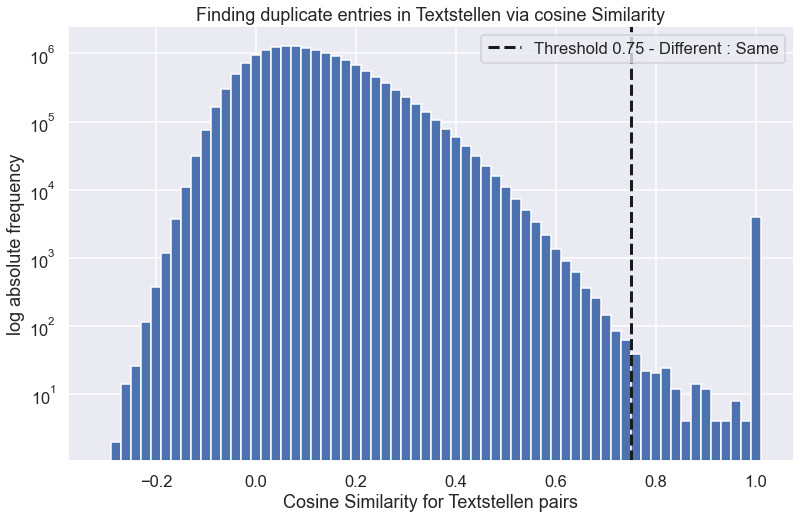

In [5]:
thrsh = 0.75

plt.figure(figsize=(13, 8))
plt.hist(M.reshape(-1),
         bins=np.arange(-0.32, 1.02, 0.02)+0.01)
plt.yscale("log")
plt.title("Finding duplicate entries in Textstellen via cosine Similarity")
plt.xlabel("Cosine Similarity for Textstellen pairs")
plt.ylabel("log absolute frequency")
plt.axvline(thrsh, lw=3, ls="--", c="k", label=f"Threshold {thrsh} - Different : Same");
plt.legend();

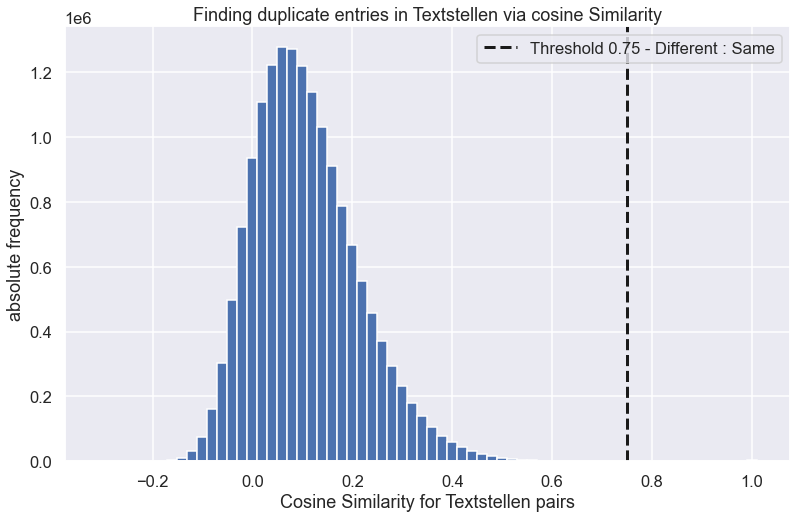

In [6]:
plt.figure(figsize=(13, 8))
plt.hist(M.reshape(-1),
         bins=np.arange(-0.32, 1.02, 0.02)+0.01)
#plt.yscale("log")
plt.title("Finding duplicate entries in Textstellen via cosine Similarity")
plt.xlabel("Cosine Similarity for Textstellen pairs")
plt.ylabel("absolute frequency")
plt.axvline(thrsh, lw=3, ls="--", c="k", label=f"Threshold {thrsh} - Different : Same");
plt.legend();

In [7]:
((M.reshape(-1) < 1) & (thrsh < M.reshape(-1))).sum()

170

In [8]:
drop_list = []

for idx in range(len(df)):
    
    new_indices = M[idx]
    new_indices = new_indices.argsort()
    new_indices = new_indices[::-1]
    
    for new_idx in new_indices:
        
        # only look at pairs once
        if idx >= new_idx:
            continue
            
        # once the entries are no longer similar, continue
        # 0.796
        if M[idx, new_idx] < thrsh:
            continue
            
        print("TEXTSTELLE:")
        print(df.loc[idx, "Textstelle"])
        print("ÄHNLICHE TEXTSTELLEN:")

        print(M[idx, new_idx].round(3))
        print(df.loc[new_idx, "Textstelle"])
        print(idx, new_idx)
        
        # add shorter part to droplist
        if len(df.Textstelle[idx]) >= len(df.Textstelle[new_idx]):
            drop_list.append(new_idx)
        else:
            drop_list.append(idx)
        
        #if input("\tDOES THIS MATCH?").lower() == "y":
        #    print(idx, new_idx)
        #    print()
        #    break
        print()
        
print("length: ", len(drop_list))

TEXTSTELLE:
Eine sammlung von preisscliristenz Herausgegeben von prof. P. S. S. Ziegler in Verbindung mit Drob Dr. Sonraa und Drob Dr. Saeclrel Erster Teil.
ÄHNLICHE TEXTSTELLEN:
0.838
Eine Sammlung von preisscliristenz Herausgegeben von Prof. Dr. S. E. Ziegler in Verbindung mit prof. Dr. Sonracl und prof. Dr. Baeclkei.
0 1001

TEXTSTELLE:
Eine sammlung von preisscliristenz Herausgegeben von prof. P. S. S. Ziegler in Verbindung mit Drob Dr. Sonraa und Drob Dr. Saeclrel Erster Teil.
ÄHNLICHE TEXTSTELLEN:
0.795
Eine Sammlung von preisschristen Herausgegeben von prof. Dr. B. E. Ziegler in Verbindung mit prof. Dr. Sonrad und prof. Dr. öaecheb Achter Teil.
0 2500

TEXTSTELLE:
Eine sammlung von preisscliristenz Herausgegeben von prof. P. S. S. Ziegler in Verbindung mit Drob Dr. Sonraa und Drob Dr. Saeclrel Erster Teil.
ÄHNLICHE TEXTSTELLEN:
0.768
Eine sammlung von Preissairisten öerausgegeben von Prof. Dr. B. S. Ziegler in Verbindung mit prof. Dr. Sonraci und prof. Dr. ökonomie.
0 1500

TEXT

TEXTSTELLE:
Sind die Prinzipien der Descendenztheorie auf die inner- politische Entwickelung und Gesetzgebung der Staaten an- zuwenden?
ÄHNLICHE TEXTSTELLEN:
0.931
Können die Prinzipien der Descendenzteorie auf die innerpolitische Entwicklung und Gesetzgebung der Staaten angewandt werden?
359 360

TEXTSTELLE:
Sind die Prinzipien der Descendenztheorie auf die inner- politische Entwickelung und Gesetzgebung der Staaten an- zuwenden?
ÄHNLICHE TEXTSTELLEN:
0.823
Was lernen wir aus den Prinzipien der Deszendenztheorie in Beziehung auf die innerpolitische Entwickelung und Gesetzgebung der Staaten?
359 3502

TEXTSTELLE:
Können die Prinzipien der Descendenzteorie auf die innerpolitische Entwicklung und Gesetzgebung der Staaten angewandt werden?
ÄHNLICHE TEXTSTELLEN:
0.795
Was lernen wir aus den Prinzipien der Deszendenztheorie in Beziehung auf die innerpolitische Entwickelung und Gesetzgebung der Staaten?
360 3502

TEXTSTELLE:
Die beiden ersten Ausdrücke heben die objektive Seite hervor: »etwa

TEXTSTELLE:
Es mag sein, daß auch bei den Tieren mit »dauernder Paarung" »ein psychisches Verhältnis zwischen den gepaarten Individuen« zu finden ist; aber logisch ist es unzulässig, umgekehrt aus diesem Verhältnisse, nennen wir es Liebe der Eltern zueinander, auf die Monogamie zu schließen: denn es muß eben angenommen werden, daß die von aller Begehrlichkeit befreite Liebe eben erst das Produkt der Monogamie ist; d. h. Ziegler begeht den Fehler, daß er umgekehrt aus der in der Geschichte auftretenden Erscheinung der Liebe der Eltern zueinander auf die Ursprünglichkeit der Monogamie schließt.
ÄHNLICHE TEXTSTELLEN:
0.756
Schlimm steht es aber gleichfalls, wenn man aus der Liebe der Eltern zu dem Kinde auf eine Monogamie zurückschlieszen will: denn unter den übrigen Tieren ist eine lebenslängliche Liebe zu dem Produkte der geschlechtlichen Verbindung vollständig unbekannt2).
1881 1882

TEXTSTELLE:
Meine Abhandlung ist im Jahre 1902 entstanden, als Bearbeitung des Jenaer Preisausschreiben

TEXTSTELLE:
Die Frage lautet: Was lernen wir aus den Prinzipien der Deszendenztheories in Beziehung aus die innerpolitische Entwicklung der Staaten und die Gefem gebung?
ÄHNLICHE TEXTSTELLEN:
0.899
Was lernen wir aus den Prinzipien der Deszendenztheorie in Beziehung auf die innerpolitische Entwickelung und Gesetzgebung der Staaten?
2478 3502

TEXTSTELLE:
Eine Sammlung von preisschristen Herausgegeben von prof. Dr. B. E. Ziegler in Verbindung mit prof. Dr. Sonrad und prof. Dr. öaecheb Achter Teil.
ÄHNLICHE TEXTSTELLEN:
0.811
Beiträge zur naturwissenschaftlichen Gesellschaftsketzra Eine Sammlung von Preissehristen herausgegeben von Prof. Dr. H. E. Ziegler in Verbindung mit Prof. Dr. Conrad und Prof. Dr. Hacckcl.
2500 3501

TEXTSTELLE:
Die Deszendenztheorie ergibt sich durch die Anwendung der Entwick- lungstheorie (Evolutionstheorie) auf die Welt des Organischen.
ÄHNLICHE TEXTSTELLEN:
0.811
Die Deszendenztheorie oder Ab- stammungslehre ist nur eine Anwendung der Entwicklungstheorie auf di

In [9]:
# remove false positives manually
drop_list.remove(3502) # Deszendenztheorie
drop_list.remove(1593)
drop_list.remove(298)
drop_list.remove(494)
drop_list.remove(589)
drop_list.remove(597)
#drop_list.remove(802)
drop_list.remove(2071)
drop_list.remove(1346)
drop_list.remove(1390)
drop_list.remove(1515)
drop_list.remove(1517)
drop_list.remove(1524)
drop_list.remove(1609)
drop_list.remove(1882)
drop_list.remove(2214)
drop_list.remove(2200)
drop_list.remove(2208)
drop_list.remove(2564)
drop_list.remove(2625)
drop_list.remove(2634)
drop_list.remove(2661)
drop_list.remove(2693)
drop_list.remove(2749)
drop_list.remove(2777)
drop_list.remove(2812)
drop_list.remove(3419)

In [10]:
len(drop_list)

60

In [11]:
df.drop(drop_list, inplace=True)
df.drop(columns = "index", inplace=True)
df.reset_index(inplace=True)
df.drop(columns = "index", inplace=True)
df.reset_index(inplace=True)
df

,index,Textstelle,Metapher,Kandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig
0,0,Eine sammlung von preisscliristenz Herausgegeb...,0,0,1,Nein,NaN,NaN,X,Eine sammlung von preisscliristenz Herausgegeb...
1,1,Januar 1900 veröffentlichten die Professoren H...,0,0,1,Nein,NaN,NaN,X,Januar 1900 veröffentlichten die Professoren H...
2,2,"Unter den 60 Abhandlungen und Schriften, welch...",0,0,1,Nein,NaN,NaN,X,"Unter den 60 Abhandlungen und Schriften, welch..."
3,3,In dem vorliegenden Sammelwerke werden sieben ...,0,0,1,Nein,NaN,NaN,X,In dem vorliegenden Sammelwerke werden sieben ...
4,4,"Es folgt hier zunächst das Preisausschreiben, ...",0,0,1,Nein,NaN,NaN,X,"Es folgt hier zunächst das Preisausschreiben, ..."
...,...,...,...,...,...,...,...,...,...,...
3960,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...
3961,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...
3962,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...
3963,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...


# Now we clean

In [12]:
def eliminate_substring(text, k=22):
    for ii in range(len(text)):
        remaining_text = text[ii:]
        
        jj = k
        while remaining_text[:jj] in remaining_text[jj:]:

            jj+=1
        if jj > k:
            #print(jj)
            return text[:ii] + remaining_text[jj-1:]
    # if we find no substring, just give the text back
    return text

231.09886506935686


/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_24781/3848625214.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Textstelle"] = data.Textstelle.str.replace(r'^\s*', "")
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_24781/3848625214.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Textstelle"] = data.Textstelle.str.replace(r'\s\s*', " ")
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_24781/3848625214.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Textstelle"] = data.Textstelle.str.replace(r'[ \t]+$', "")
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_24781/3848625214.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Textstelle"] = data.Textstelle.str.replace(r'\d\.', '')
/var/folders/j4/qmf6qmvd1gv0nct

226.44741488020176


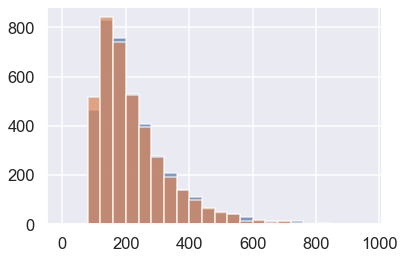

In [13]:
bins = np.arange(0, 1000, 40)
data = df.copy()
data["Textstelle"].str.len().hist(bins=bins, alpha = 0.7);
print(data["Textstelle"].str.len().mean())

#remove quotes
data["Textstelle"] = data.Textstelle.str.replace('"', '')
data["Textstelle"] = data.Textstelle.str.replace("'", '')
data["Textstelle"] = data.Textstelle.str.replace(r'»', '')
data["Textstelle"] = data.Textstelle.str.replace(r'«', '')
data["Textstelle"] = data.Textstelle.str.replace(r'„', '')
data["Textstelle"] = data.Textstelle.str.replace(r'“', '')

#remove newline connection:
data["Textstelle"] = data.Textstelle.str.replace(r'— ', '')
data["Textstelle"] = data.Textstelle.str.replace(r'- ', '')

#remove leading/trailing whitespace
data["Textstelle"] = data.Textstelle.str.replace(r'^\s*', "")
data["Textstelle"] = data.Textstelle.str.replace(r'\s\s*', " ")
data["Textstelle"] = data.Textstelle.str.replace(r'[ \t]+$', "")

#remove digits
data["Textstelle"] = data.Textstelle.str.replace(r'\d\.', '')
data["Textstelle"] = data.Textstelle.str.replace(r'\d', '')

# remove brackets:
data["Textstelle"] = data.Textstelle.str.replace(r'\[', '')
data["Textstelle"] = data.Textstelle.str.replace(r'\]', '')
data["Textstelle"] = data.Textstelle.str.replace(r'\(', '')
data["Textstelle"] = data.Textstelle.str.replace(r'\)', '')

# remove special characters
# YES, we remove dots. But they need to be added again at the end
#data["Textstelle"] = data.Textstelle.str.replace(r'.', '')
data["Textstelle"] = data.Textstelle.str.replace(r':', '')
data["Textstelle"] = data.Textstelle.str.replace(r';', '')
data["Textstelle"] = data.Textstelle.str.replace(r'—', '')
data["Textstelle"] = data.Textstelle.str.replace(r'- ', '') # linebreak extension
data["Textstelle"] = data.Textstelle.str.replace(r'-', '')
data["Textstelle"] = data.Textstelle.str.replace(r'_', '')

# make sure Commas come after a word:
data["Textstelle"] = data.Textstelle.str.replace(r' ,', ',')

# Roman numerals
data["Textstelle"] = data.Textstelle.str.replace(r'^I{0,3}V{0,1}I{0,3} ', "")
data["Textstelle"] = data.Textstelle.str.replace(r'^I{0,1}X{1,2}I{0,3} ', "")


data["Kürzungen"] = 0
for i in range(6):
    new_data = data["Textstelle"].apply(eliminate_substring)
    data["Kürzungen"] += (data["Textstelle"] != new_data)
    data["Textstelle"] = new_data

data.drop("Kürzungen", axis=1, inplace=True)
    
data["Textstelle"].str.len().hist(bins=bins, alpha = 0.7);
print(data["Textstelle"].str.len().mean())

In [14]:
import os

cwd = os.getcwd()
folder = "clean+translated-data"
file = "non-metaphor-clean-de.csv"
path = "/".join( (cwd, folder, file) )

data = data.set_index("index")
data.to_csv(path)